# Word tagging exercice


In [1]:
# Header
from __future__ import print_function

import numpy as np
import keras
print('Keras version: ', keras.__version__)

# GPU devices visible by python
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="2"

# Limit memory usage
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))



Using TensorFlow backend.


Keras version:  2.0.0


## Data

In [3]:
import numpy as np 

import pickle

atis_file = '/home/ubuntu/data/training/text/atis/atis.pkl'
with open(atis_file,'rb') as f:
    train, test, dicts = pickle.load(f, encoding='bytes')
    

## train / test sets:
    - X: list of sequences
    - ne: PENDING
    - label: name entities
## Dictionaries
    - labels2idx
    - words2idx

In [4]:
# Visualize data
w2idx, ne2idx, labels2idx = dicts[b'words2idx'], dicts[b'tables2idx'], dicts[b'labels2idx']
    
idx2w  = dict((v,k) for k,v in w2idx.items())
idx2ne = dict((v,k) for k,v in ne2idx.items())
idx2la = dict((v,k) for k,v in labels2idx.items())

train_x, train_ne, train_label = train
test_x,  test_ne,  test_label  = test
wlength = 35

for e in ['train','test']:
    print(e)
    for sw, se, sl in zip(eval(e+'_x')[:5], eval(e+'_ne')[:5], eval(e+'_label')[:10]):
        print( 'WORD'.rjust(wlength), 'LABEL'.rjust(wlength))
        for wx, la in zip(sw, sl): print( idx2w[wx].rjust(wlength), idx2la[la].rjust(wlength))
        print( '\n'+'**'*30+'\n')


train
                               WORD                               LABEL
b'                                  i' b'                                  O'
b'                               want' b'                                  O'
b'                                 to' b'                                  O'
b'                                fly' b'                                  O'
b'                               from' b'                                  O'
b'                             boston' b'                B-fromloc.city_name'
b'                                 at' b'                                  O'
b'                    DIGITDIGITDIGIT' b'                 B-depart_time.time'
b'                                 am' b'                 I-depart_time.time'
b'                                and' b'                                  O'
b'                             arrive' b'                                  O'
b'                                 in' b'                       

# Model

For each word in the sentence, predict the label

First, for each word in each sentence, generate  the context with the previous and next words in the sentence.
This create a train dataset of num_sentences*

In [5]:
def context(l, size=3):
    l = list(l)
    lpadded = size // 2 * [572] + l + size // 2 * [572]
    out = [lpadded[i:(i + size)] for i in range(len(l))]
    return out

x = np.array([0, 1, 2, 3, 4], dtype=np.int32)
context(x)

[[572, 0, 1], [0, 1, 2], [1, 2, 3], [2, 3, 4], [3, 4, 572]]

In [6]:
X_trn=[]
for s in train_x:
    X_trn += context(s,size=10)
X_trn = np.array(X_trn)

X_tst=[]
for s in test_x:
    X_tst += context(s,size=10)
X_tst = np.array(X_tst)

print(X_trn.shape, X_tst.shape)

(56590, 10) (9198, 10)


In [7]:
y_trn=[]
for s in train_label:
    y_trn += list(s)
y_trn = np.array(y_trn)

y_tst=[]
for s in test_label:
    y_tst += list(s)
y_tst = np.array(y_tst)
print(y_trn.shape, y_tst.shape)

(56590,) (9198,)


In [8]:
print('Num categories: ', len(set(y_trn)))
print('Dictionary size: ', len(set(idx2w)))

Num categories:  121
Dictionary size:  572


In [9]:
#Model parameters

input_seq_length = X_trn.shape[1]
input_vocabulary_size = len(set(idx2w)) + 1
output_length = 127
num_hidden_lstm = 128

In [10]:
# build the model: Simple LSTM with embedings
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM, Embedding

print('Build model 1')
seq_input = Input(shape=([input_seq_length]), name='prev') 
    
embeds = Embedding(input_vocabulary_size, 64)(seq_input)
    
# apply forwards LSTM
#forwards1 = LSTM(512, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)(embed)

forwards = LSTM(num_hidden_lstm, return_sequences=False)(embeds)

output = Dense(output_length, activation='softmax')(forwards)

model1 = Model(inputs=seq_input, outputs=output)
model1.summary()

# Optimizer
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Build model 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prev (InputLayer)            (None, 10)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 64)            36672     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 127)               16383     
Total params: 151,871.0
Trainable params: 151,871.0
Non-trainable params: 0.0
_________________________________________________________________


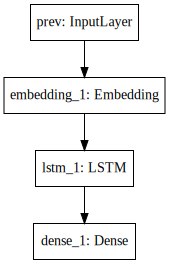

In [12]:
#Plot the model graph
from IPython.display import SVG
from keras.utils import vis_utils

SVG(vis_utils.model_to_dot(model1).create(prog='dot', format='svg'))

In [14]:
#Fit model
history = model1.fit(X_trn, y_trn, batch_size=128, epochs=10,
           validation_data=(X_tst, y_tst))


Train on 56590 samples, validate on 9198 samples
Epoch 1/10
56590/56590 [==============================] - 10s - loss: 0.9751 - acc: 0.7679 - val_loss: 0.7022 - val_acc: 0.8324
Epoch 2/10
56590/56590 [==============================] - 10s - loss: 0.4386 - acc: 0.8958 - val_loss: 0.3955 - val_acc: 0.9101
Epoch 3/10
56590/56590 [==============================] - 10s - loss: 0.2400 - acc: 0.9444 - val_loss: 0.2897 - val_acc: 0.9361
Epoch 4/10
56590/56590 [==============================] - 10s - loss: 0.1650 - acc: 0.9621 - val_loss: 0.2196 - val_acc: 0.9538
Epoch 5/10
56590/56590 [==============================] - 10s - loss: 0.1206 - acc: 0.9724 - val_loss: 0.2220 - val_acc: 0.9562
Epoch 6/10
56590/56590 [==============================] - 10s - loss: 0.0947 - acc: 0.9785 - val_loss: 0.1864 - val_acc: 0.9633
Epoch 7/10
56590/56590 [==============================] - 10s - loss: 0.0763 - acc: 0.9825 - val_loss: 0.1746 - val_acc: 0.9669
Epoch 8/10
56590/56590 [==============================]

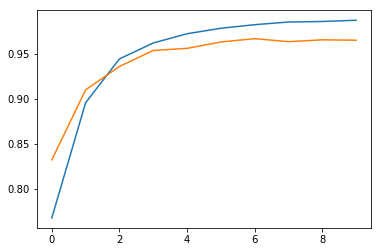

In [15]:
#Plot graphs in the notebook output
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

In [16]:
# build the model: Bidirectional LSTM with embedings
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM, Embedding, Merge, Bidirectional

print('Build model 2')
seq_input = Input(shape=([input_seq_length]), name='prev') 
    
embeds = Embedding(input_vocabulary_size, 64)(seq_input)
    
# Bidirectional wrapper
rnn_out = Bidirectional(LSTM(num_hidden_lstm))(embeds)

output = Dense(output_length, activation='softmax')(rnn_out)

model2 = Model(inputs=seq_input, outputs=output)
model2.summary()

# Optimizer
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Build model 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prev (InputLayer)            (None, 10)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 10, 64)            36672     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               197632    
_________________________________________________________________
dense_2 (Dense)              (None, 127)               32639     
Total params: 266,943.0
Trainable params: 266,943.0
Non-trainable params: 0.0
_________________________________________________________________


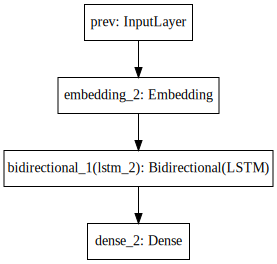

In [17]:
#Plot the model graph
SVG(vis_utils.model_to_dot(model2).create(prog='dot', format='svg'))

In [18]:
#Fit model
history2 = model2.fit(X_trn, y_trn, batch_size=128, epochs=10,
           validation_data=(X_tst, y_tst))


Train on 56590 samples, validate on 9198 samples
Epoch 1/10
56590/56590 [==============================] - 19s - loss: 1.5020 - acc: 0.6748 - val_loss: 1.0172 - val_acc: 0.7380
Epoch 2/10
56590/56590 [==============================] - 19s - loss: 0.5784 - acc: 0.8508 - val_loss: 0.4199 - val_acc: 0.8968
Epoch 3/10
56590/56590 [==============================] - 19s - loss: 0.2474 - acc: 0.9359 - val_loss: 0.2750 - val_acc: 0.9367
Epoch 4/10
56590/56590 [==============================] - 18s - loss: 0.1431 - acc: 0.9641 - val_loss: 0.2160 - val_acc: 0.9571
Epoch 5/10
56590/56590 [==============================] - 19s - loss: 0.0992 - acc: 0.9756 - val_loss: 0.1996 - val_acc: 0.9610
Epoch 6/10
56590/56590 [==============================] - 19s - loss: 0.0769 - acc: 0.9808 - val_loss: 0.1800 - val_acc: 0.9650
Epoch 7/10
56590/56590 [==============================] - 19s - loss: 0.0614 - acc: 0.9843 - val_loss: 0.1729 - val_acc: 0.9680
Epoch 8/10
56590/56590 [==============================]

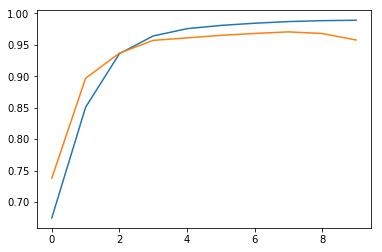

In [19]:
#Plot graphs in the notebook output
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.show()